In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np




In [2]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [3]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_50.pkl


In [10]:

def make_batch(buffer_state, key):
    key, sampling_key, batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, next_state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, next_state, future_state, goal_index = get_single_pair_from_every_env(
        state,
        next_state,
        future_state,
        goal_index,
        sampling_key,
    )
    if not config.exp.use_targets:
        state = state.replace(grid=remove_targets(state.grid))
        next_state = next_state.replace(grid=remove_targets(next_state.grid))
        future_state = future_state.replace(grid=remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        "observations": state.grid.reshape(state.grid.shape[0], -1),
        "next_observations": next_state.grid.reshape(next_state.grid.shape[0], -1),
        "actions": actions.squeeze(),
        "rewards": state.reward.reshape(state.reward.shape[0], -1).squeeze(),
        "masks": 1.0 - state.done.reshape(state.done.shape[0], -1).squeeze(),
        "value_goals": future_state.grid.reshape(future_state.grid.shape[0], -1),
        "actor_goals": future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

In [11]:
key = random.PRNGKey(0)

In [12]:
buffer_state, batch = make_batch(buffer_state, key)

In [13]:
batch.keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'masks', 'value_goals', 'actor_goals'])

In [14]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6


In [15]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  25., 996.]),
 array([0.9911148 , 1.07117903, 1.15124333, 1.23130763, 1.31137192,
        1.39143622, 1.47150052, 1.55156481, 1.63162911, 1.71169341,
        1.7917577 ]),
 <BarContainer object of 10 artists>)

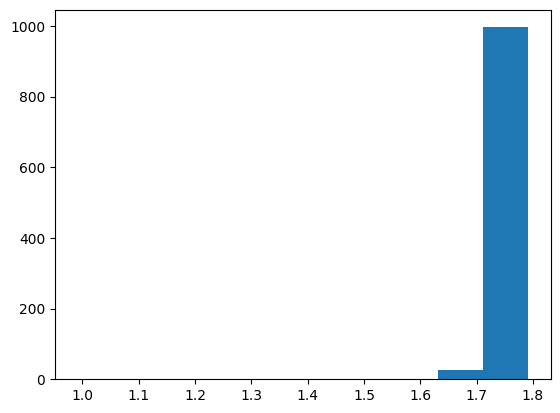

In [16]:
plt.hist(dist.entropy())

In [17]:
use_targets = False

timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=remove_targets(timesteps.grid),
        goal=remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [18]:
tr_states.shape

(100, 1024, 5, 5)

In [19]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 5, 5)

In [20]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape

(100, 25)

2025-08-31 20:57:02.270217: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


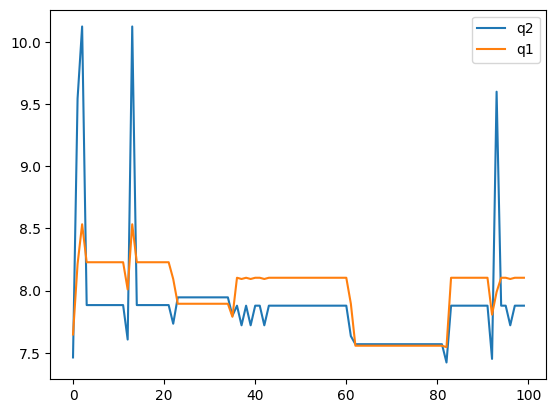

In [21]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

plt.plot(q2, label='q2')
plt.plot(q1, label='q1')
plt.legend()
plt.show()

In [22]:
all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, traj_goals, all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6

qs.shape


2025-08-31 20:57:29.276040: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


(100, 6)

In [23]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.entropy().shape

(100,)

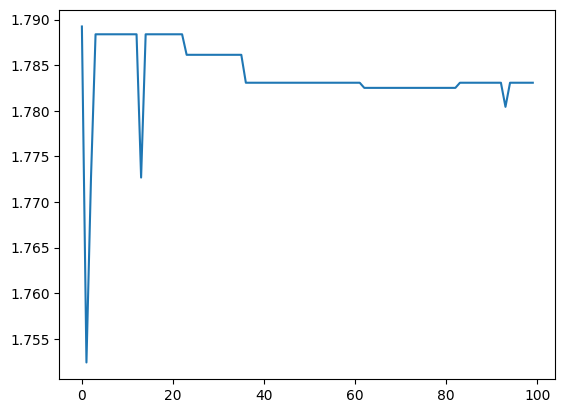

In [24]:
plt.plot(list(range(qs.shape[0])), dist.entropy(), label='entropy')

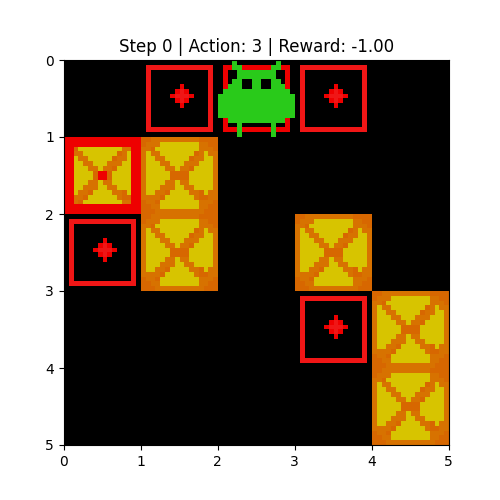

In [25]:
import IPython.display as display

grid_size = state.grid.shape[-2:]
fig, ax = plt.subplots(figsize=grid_size)

animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

# Save as GIF
gif_path = f"/tmp/block_moving_epoch.gif"
anim.save(gif_path, writer='pillow')
plt.close()


# Visualize the GIF in the notebook
display.display(display.Image(filename=gif_path))


# Entropy for different checkpoints

In [26]:
timesteps_tr.grid.shape

(100, 1024, 5, 5)

In [27]:
timesteps.grid[0,0]

Array([[ 0, 10,  2,  0,  0],
       [ 2,  1,  1,  0,  0],
       [ 6,  0,  0,  0,  0],
       [ 2,  0,  1,  2,  0],
       [ 0,  0,  0,  1,  1]], dtype=int8)

In [28]:
timesteps_for_goal = jax.tree_util.tree_map(lambda x: x[0,0], timesteps)

In [29]:
actual_goal = create_solved_state(timesteps_for_goal).grid
actual_goal

Array([[ 0, 10, 10,  0,  0],
       [10,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0],
       [10,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0]], dtype=int8)

In [30]:
goal = jnp.tile(actual_goal, (100, 1,1))  # Repeat the goal for each state in the trajectory
print(goal.shape)
goal[1]

(100, 5, 5)


Array([[ 0, 10, 10,  0,  0],
       [10,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0],
       [10,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0]], dtype=int8)

In [31]:
goal = goal.reshape(goal.shape[0], -1)  # Flatten the goal for each state
goal.shape
goal = GridStatesEnum.remove_targets(goal)
goal[0]

AttributeError: type object 'GridStatesEnum' has no attribute 'remove_targets'

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_0.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_10.pkl


Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_20.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_30.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_40.pkl
Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_20250830_234407/runs/fixed_dqn_and_wrapper_eps_greedy_dense_10_dqn_moving_boxes_5_grid_5_range_3_7_alpha_0.3_expc_0.5/params_50.pkl


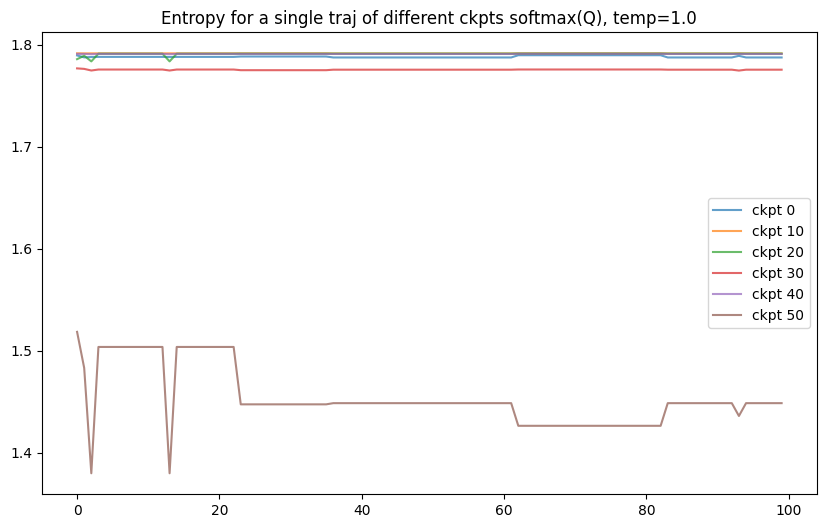

In [32]:
plt.figure(figsize=(10, 6))
for ckpt in range(0,EPOCHS,EVAL_EVERY):
    agent, config = restore_agent(example_batch, MODEL_PATH, ckpt)

    all_actions = jnp.tile(jnp.arange(6), (traj_states.shape[0], 1))  # B x 6
    qs = jax.lax.stop_gradient(
        jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(traj_states, goal, all_actions)
    )  # 6 x 2 x B
    qs = qs.min(axis=1)  # 6 x B
    qs = qs.transpose(1, 0)  # B x 6
    dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
    plt.plot(list(range(qs.shape[0])), dist.entropy(), label=f'ckpt {ckpt}', alpha=0.7)

plt.title("Entropy for a single traj of different ckpts softmax(Q), temp=1.0")
plt.legend()
plt.show()

In [40]:
tr_actions.shape

(100, 1024)

(array([ 34467.,  70902.,  99123., 130835., 187064., 190858., 130835.,
         99123.,  70902.,  34467.]),
 array([-487. , -389.6, -292.2, -194.8,  -97.4,    0. ,   97.4,  194.8,
         292.2,  389.6,  487. ]),
 <BarContainer object of 10 artists>)

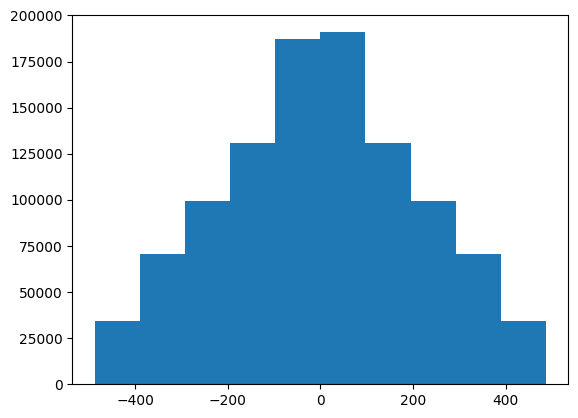

In [50]:
plt.hist((tr_actions.T[None, :] - tr_actions.T[:, None]).sum(axis=-1).reshape(-1))

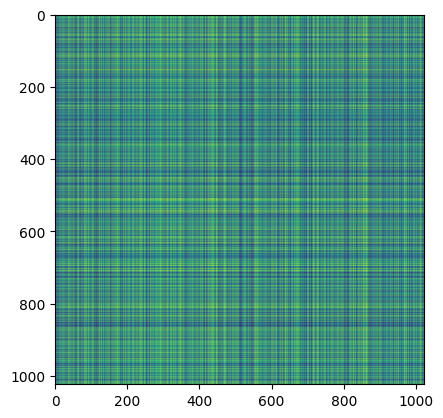

In [ ]:
plt.imshow((tr_actions.T[None, :] - tr_actions.T[:, None]).sum(axis=-1))

In [41]:
tr_actions[:, 0]

Array([3, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 0, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 0, 5, 0, 5, 5, 0, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 1, 0, 5, 5, 0, 5, 5, 5], dtype=int32)

(array([22919.,     0., 10014.,     0., 14098.,     0.,  7382.,     0.,
        21575., 26412.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

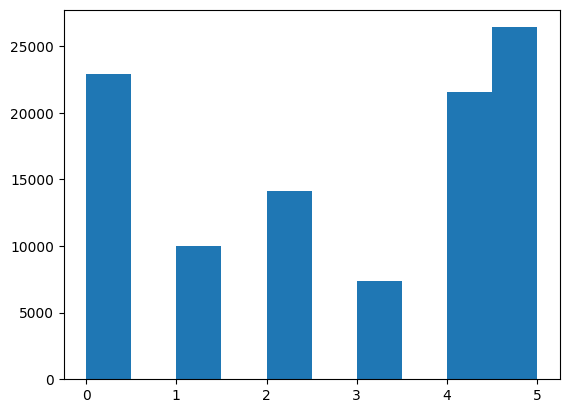

In [39]:
plt.hist(tr_actions.reshape(-1))

In [73]:
((tr_actions[None, :] ==tr_actions[ :, None]).all(axis=-1)).sum()

Array(100, dtype=int32)

# Investigation of DQN

In [54]:
buffer_state, batch = make_batch(buffer_state, key)

In [ ]:
batch['observations'].shape

(1024, 25)

In [66]:
((batch['observations'][None, :] -batch['observations'][ :, None]).sum(axis=-1)==0).sum()

Array(193252, dtype=int32)

(array([  3660.,  49632.,  85088., 336806., 205904., 285882.,  73644.,
          5744.,   1188.,   1028.]),
 array([ 9. , 10.6, 12.2, 13.8, 15.4, 17. , 18.6, 20.2, 21.8, 23.4, 25. ]),
 <BarContainer object of 10 artists>)

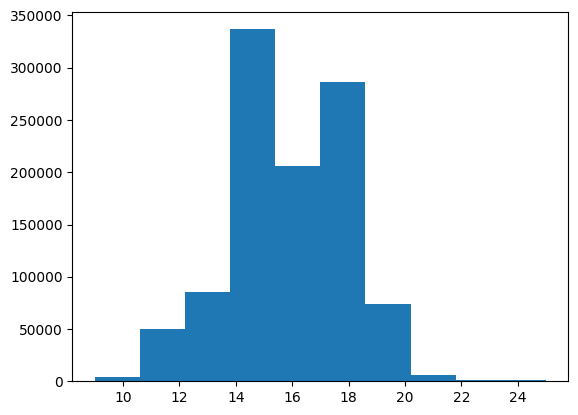

In [86]:
plt.hist((batch['observations'][None, :] ==batch['observations'][ :, None]).sum(axis=-1).reshape(-1))

In [ ]:
((batch['observations'][None, :] ==batch['observations'][ :, None]).all(axis=-1)).sum()

Array(1024, dtype=int32)

In [74]:
q1_a, q2_a = agent.network.select('critic')(
    batch['observations'], batch['value_goals'], batch['actions'], params=None
)


In [75]:
q1_a.shape, q1_a

((1024,),
 Array([17.407927 ,  3.843251 ,  1.306445 , ...,  2.511557 ,  0.8678783,
         4.047804 ], dtype=float32))

In [59]:
# Ensure shapes are (batch,)
q1_a = jnp.squeeze(q1_a, axis=-1) if q1_a.ndim > 1 else q1_a
q2_a = jnp.squeeze(q2_a, axis=-1) if q2_a.ndim > 1 else q2_a
q1_a.shape, q1_a

((1024,),
 Array([17.407927 ,  3.843251 ,  1.306445 , ...,  2.511557 ,  0.8678783,
         4.047804 ], dtype=float32))

This seems OK so far

In [76]:
all_actions = jnp.tile(jnp.arange(6), (batch['next_observations'].shape[0], 1))  # B x 6
all_actions.shape

(1024, 6)

In [77]:
qs = jax.lax.stop_gradient(jax.vmap(agent.network.select('target_critic'), in_axes=(None, None, 1))(batch['next_observations'], batch['value_goals'], all_actions)) # 6 x 2 x B
print(qs.shape)
qs = qs.mean(axis=1) # 6 x B
print(qs.shape)
qs = qs.transpose(1, 0) # B x 6
print(qs.shape)

(6, 2, 1024)
(6, 1024)
(1024, 6)


In [78]:
max_next_q = jnp.max(qs, axis=-1)
max_next_q.shape

(1024,)

In [79]:
batch['masks'].shape, batch['rewards'].shape

((1024,), (1024,))

In [82]:
jnp.unique(batch['masks'])

Array([1.], dtype=float32, weak_type=True)

In [80]:
target = batch['rewards'] + 0.99 * batch['masks'] * max_next_q
target.shape

(1024,)

It seems like there is no problem with shapes